# Example 2

This is an example that reproduces Figure 4 from the main text. First, we generate synthetic data from the ramping and stepping dynamics and optimize the model on these data, and visualize the results. Next, we perform simultaneous inference of model potential, diffusion coefficient, and initial distribution of the latent states from data that was generated from the ramping dynamics. This code is adopted for neuralflow version 3.

In [1]:
import neuralflow
import numpy as np
import matplotlib.pyplot as plt, matplotlib.gridspec as gridspec
from neuralflow.utilities.visualization_functions import plot_spikes, plot_fitting_results
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Step 1: Generate synthetic data from the ramping and stepping dynamics.

1) Specify grid parameters: number of points per element and number of elemets. 

2) Specify the ground-truth models for data generation for ramping and stepping models, see the peq_models and firing_rate_models for built-in options. 

3) Generate 400 trials of data from each model, each trial has 100 seconds, each trial will have 100 seconds maximum duration (however, all of them will terminate earlier due to absorption at the decision boundary, with the average trial duration time less than 1 second).    

4) (OPTIONAL) Visualize latent trajectories and spike rasters of the generated data. First of all, for each of the 400 generated latent trajectories, find the termination side (left or right boundary). Select 3 example trials where the latent trajectory terminated on the left, and 6 trials where the latent trajectory terminated on the right boundary. Plot latent trajectories and the corresponding spike rasters for the example nine trials.

In [2]:
grid = neuralflow.GLLgrid(Np = 8, Ne = 64)
gt_ramping = neuralflow.model.new_model(
    peq_model = {"model": "linear_pot", "params": {"slope": -2.65}},
    p0_model = {"model": "single_well", "params": {"miu": 200, "xmin": 0}},
    D = 0.56,
    fr_model = [{"model": "linear", "params": {"slope": 50, "bias": 60}}],
    grid = grid
)

gt_stepping = neuralflow.model.new_model(
    peq_model = {"model": "stepping", "params": {"interp_x": [-1, -0.5, 0, 0.3, 1], "interp_y": [0, 4, 0, 1, -1]}},
    p0_model = {"model": "single_well", "params": {"miu": 200, "xmin": 0}},
    D = 1,
    fr_model = [{"model": "linear", "params": {"slope": 50, "bias": 60}}],
    grid = grid
)

data_generator_ramping = neuralflow.SyntheticData(gt_ramping, 'absorbing')
data_ramping, time_bins_ramping, diff_traj_ramping = data_generator_ramping.generate_data(trial_start = 0, trial_end = 100, num_trials = 400)

data_generator_stepping = neuralflow.SyntheticData(gt_stepping, 'absorbing')
data_stepping, time_bins_stepping, diff_traj_stepping = data_generator_stepping.generate_data(trial_start = 0, trial_end = 100, num_trials = 400)


100%|██████████| 400/400 [00:35<00:00, 11.38it/s]


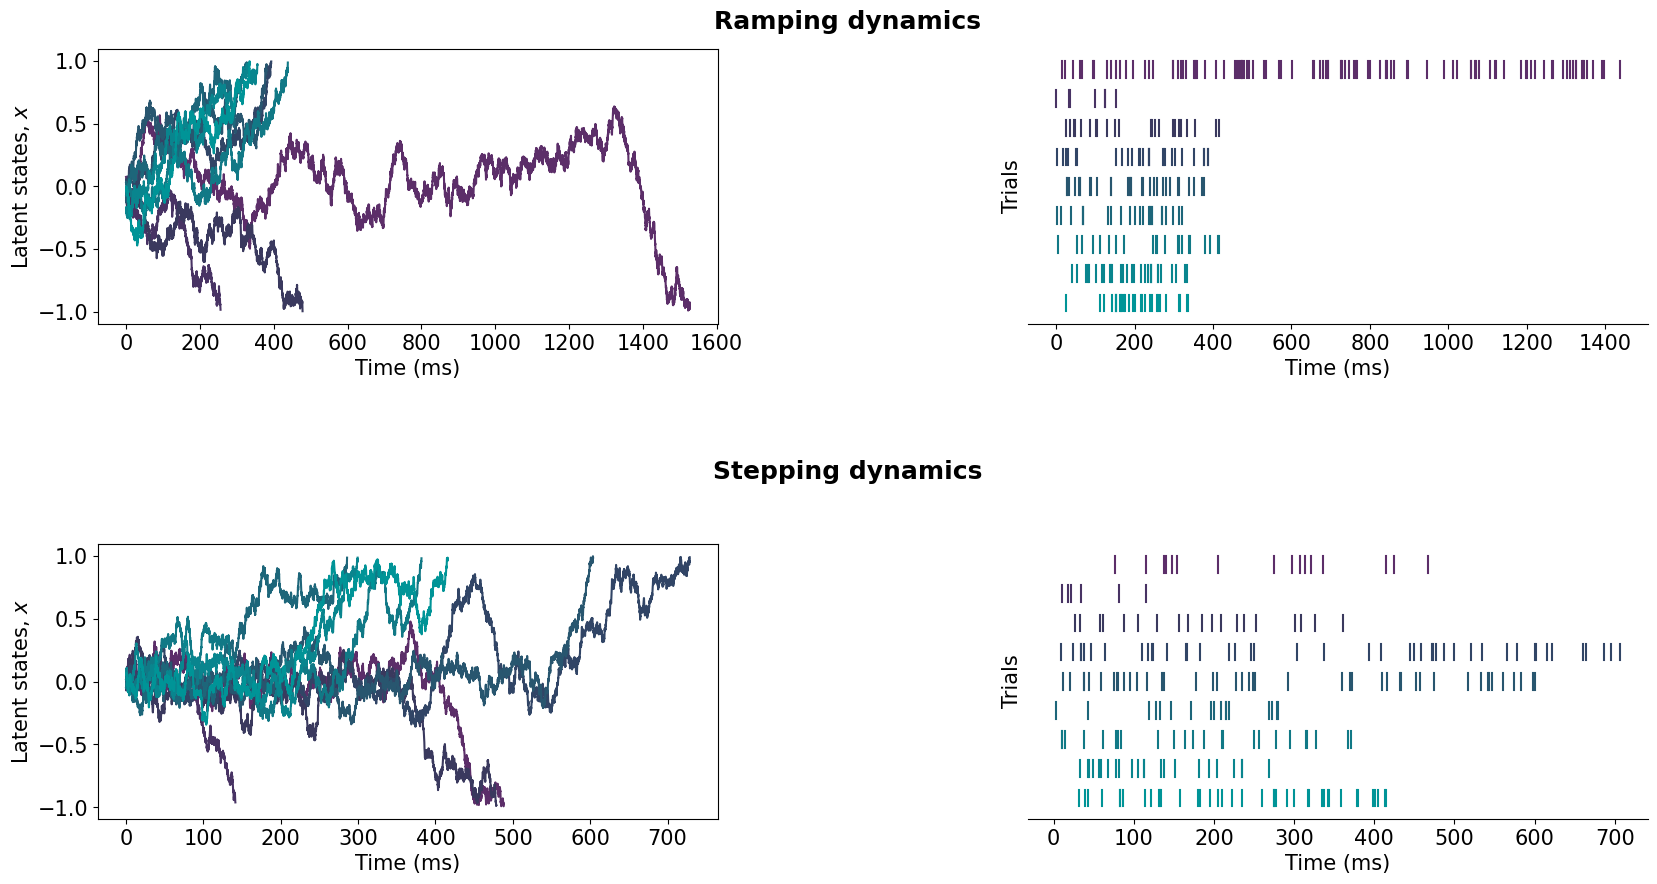

In [3]:
#(OPTIONAL): Visualize the latent trajectories and spike rasters of the generated data
fig=plt.figure(figsize=(20,10))
gs=gridspec.GridSpec(2,2,wspace=0.5, hspace=0.8)
colors=[[0, 0.5804, 0.5922], [0.0353, 0.5216, 0.5569], [0.0667, 0.4745, 0.5255],
[0.1137, 0.4000, 0.4784], [0.1569, 0.3373, 0.4353], [0.1922, 0.2706, 0.4000],
[0.2275, 0.2235, 0.3686], [0.2824, 0.2000, 0.3922], [0.3608, 0.1804, 0.4118]]
colors.reverse()

# Plot ramping model
fig.text(0.5,0.9,'Ramping dynamics',fontsize=18,horizontalalignment='center',fontweight='bold')

# Find where each of the latent trajectories teminate (1 if the right boundary, -1 if the left boundary):
bnd=np.array([1 if diff_traj_ramping[i][-1]>0 else -1 for i in range(400)])

# Take 3 example trajectories that terminate on the left boundary, and 6 that terminate on the right boundary
if np.where(bnd==-1)[0].size<3:
    print('Due to bad luck there are less than 3 trials out of 200 that terminate on the left boundary. Please rerun the previous cell to generate new data, and then rerun this cell')
traj_indeces=np.concatenate((np.where(bnd==-1)[0][:3],np.where(bnd==1)[0][:6]))

# Plot latent trajectories
ax = plt.subplot(gs[0])
for i in range(9):
    plt.plot(time_bins_ramping[traj_indeces[i]]*1000,diff_traj_ramping[traj_indeces[i]],color=colors[i])
plt.xlabel('Time (ms)',fontsize=15)
plt.ylabel(r'Latent states, $x$',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

# Plot spikes
ax = plt.subplot(gs[1])
plot_spikes(data_ramping[list(traj_indeces)],ax,colors)
plt.xlabel('Time (ms)',fontsize=15)
plt.ylabel('Trials',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

# Plot stepping model
fig.text(0.5,0.45,'Stepping dynamics',fontsize=18,horizontalalignment='center',fontweight='bold')

# Find where each of the latent trajectories teminate (1 if the right boundary, -1 if the left boundary):
bnd=np.array([1 if diff_traj_stepping[i][-1]>0 else -1 for i in range(400)])

# Take 3 example trajectories that terminate on the left boundary, and 6 that terminate on the right boundary
if np.where(bnd==-1)[0].size<3:
    print('Due to bad luck there are less than 3 trials out of 200 that terminate on the left boundary. Please rerun the previous cell to generate new data, and then rerun this cell')
traj_indeces=np.concatenate((np.where(bnd==-1)[0][:3],np.where(bnd==1)[0][:6]))

# Plot latent trajectories
ax = plt.subplot(gs[2])
for i in range(9):
    plt.plot(time_bins_stepping[traj_indeces[i]]*1000,diff_traj_stepping[traj_indeces[i]],color=colors[i])
plt.xlabel('Time (ms)',fontsize=15)
plt.ylabel(r'Latent states, $x$',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = plt.subplot(gs[3])

# Plot spikes
plot_spikes(data_stepping[list(traj_indeces)],ax,colors)

plt.xlabel('Time (ms)',fontsize=15)
plt.ylabel('Trials',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

## Step 2: Optimize the model potentials using the generated data

1) For each case, specify the initial guess model. All parameters are the same as the ground-truth, but the initial guesses for the potential are the constant potentials (uniform peq models). To accelerate the evaluation of this cell, we also reduce grid resolution.

2) Convert the training data into SpikeData class that can be accepted by the optimizer.

3) Specify optimization parameters: maximum number of epochs, mini_batch_number that determine number of mini batches in the epoch (number of iterations per epoch), params_to_opt - a list of parameters to be optimized, and learning_rate - a dictionary that specify gradient-descent learning rates.

4) Initialize optimization object. optimizer_name is GD (gradient-descent), boundary mode is absorbing. 

5) Optimize the model with the selected parameters.

In [4]:
# Ramping dynamics
initial_guess_model = neuralflow.model.new_model(
    peq_model = {"model": "uniform", "params": {}},
    p0_model = {"model": "single_well", "params": {"miu": 200, "xmin": 0}},
    D = 0.56,
    fr_model = [{"model": "linear", "params": {"slope": 50, "bias": 60}}],
    grid = neuralflow.GLLgrid(Np = 8, Ne = 16)
)

dataTR = neuralflow.SpikeData(data_ramping)
opt_params = {'max_epochs': 50, 'mini_batch_number': 1, 'params_to_opt': 'F', 'learning_rate': {'F': 0.0025}}
optimization_ramping = neuralflow.Optimization(dataTR, init_model = initial_guess_model, optimizer_name = 'GD', opt_options = opt_params, boundary_mode='absorbing')
optimization_ramping.run_optimization()

# Need another model since D is different for stepping.
initial_guess_model = neuralflow.model.new_model(
    peq_model = {"model": "uniform", "params": {}},
    p0_model = {"model": "single_well", "params": {"miu": 200, "xmin": 0}},
    D = 1,
    fr_model = [{"model": "linear", "params": {"slope": 50, "bias": 60}}],
    grid = neuralflow.GLLgrid(Np = 8, Ne = 16)
)

# Stepping dynamics
dataTR = neuralflow  .SpikeData(data_stepping)
opt_params = {'max_epochs': 100, 'mini_batch_number': 1, 'params_to_opt': 'F', 'learning_rate': {'F': 0.0025}}
optimization_stepping = neuralflow.Optimization(dataTR, init_model = initial_guess_model, optimizer_name = 'GD', opt_options = opt_params, boundary_mode='absorbing')
optimization_stepping.run_optimization()

Wrapping up data into the list format
100%|██████████| 50/50 [04:35<00:00,  5.52s/it]
Wrapping up data into the list format
100%|██████████| 100/100 [07:14<00:00,  4.35s/it]


Visualize the results. In addition, we compute negative loglikelihood of the ground-truth model. Since the ground-truth model has different grid resolution than a training model, we create a grad object with the specific grid resolution that allows us to compute gradients for arbitrary data and models.

Text(0.5, 0.9, 'Ramping dynamics')

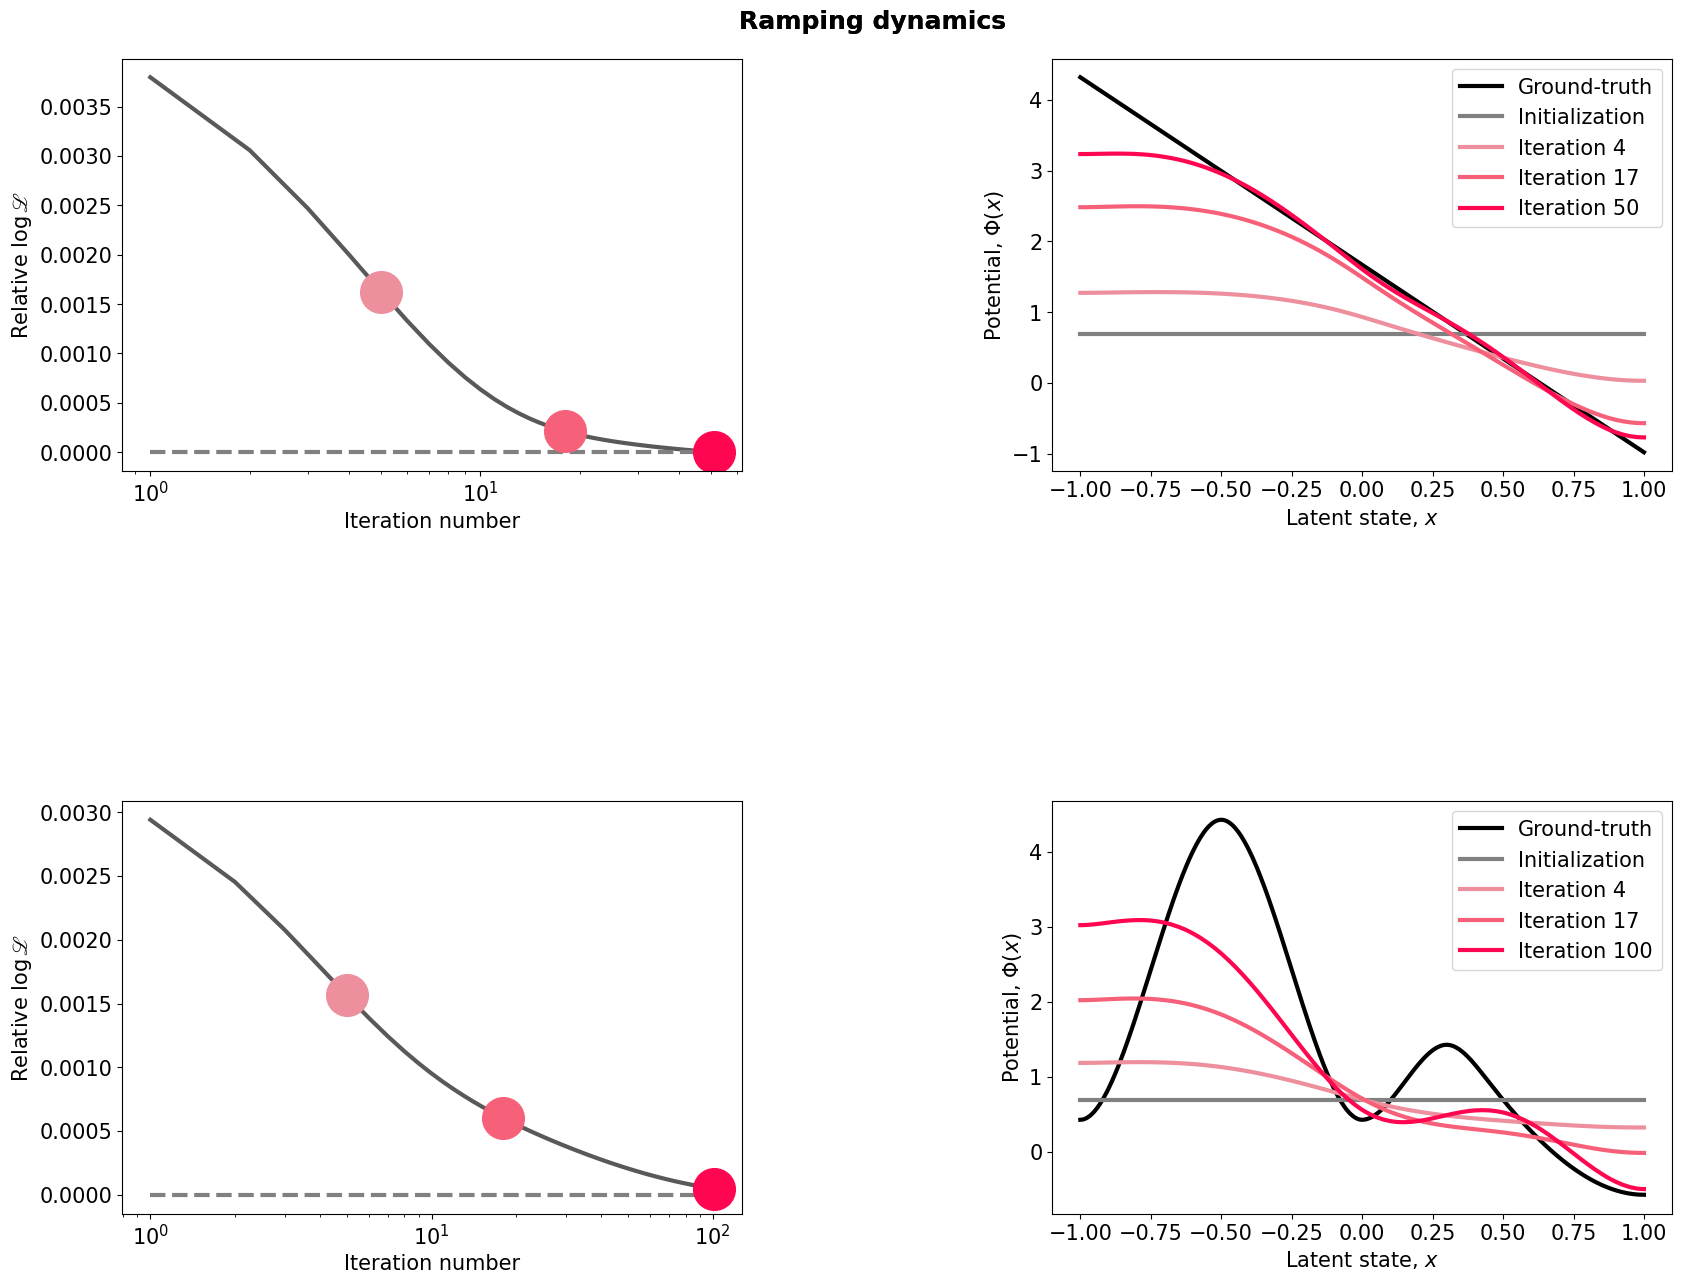

In [5]:
#Visualize the results
#Create a big figure to plot all the results
fig=plt.figure(figsize=(20,15))
gs=gridspec.GridSpec(2,2,wspace=0.5,hspace=0.8);
colors=[[0.9294, 0.5608, 0.6157], [0.9686, 0.3765, 0.4745], [1.0000, 0.0235, 0.3176]]
example_iterations=[4,17, optimization_ramping.results['logliks'][0].size-1]

# To compute negative log-likelihood of the ground-truth model, need to create a separate grad object since the grid resolution is different
grad = neuralflow.Grads(pde_solve_params = {'Np': grid.Np, 'Ne': grid.Ne}, boundary_mode = 'absorbing')
ll_gt_ramping = grad.get_grad_data(optimization_ramping.optimizer.get_dataTR(0), gt_ramping, 0)
# Plot the results for ramping model
plot_fitting_results(gs[0],gs[1], initial_guess_model, optimization_ramping.results, gt_ramping, ll_gt_ramping, example_iterations,colors)
fig.text(0.5,0.9,'Ramping dynamics',fontsize=18, horizontalalignment='center',fontweight='bold')

example_iterations=[4,17, optimization_stepping.results['logliks'][0].size-1]
grad = neuralflow.Grads(pde_solve_params = {'Np': grid.Np, 'Ne': grid.Ne}, boundary_mode = 'absorbing')
ll_gt_stepping = grad.get_grad_data(optimization_stepping.optimizer.get_dataTR(0), gt_stepping, 0)
# Plot the results for stepping model
plot_fitting_results(gs[2],gs[3], initial_guess_model, optimization_stepping.results, gt_stepping, ll_gt_stepping, example_iterations,colors)
fig.text(0.5,0.9,'Ramping dynamics',fontsize=18, horizontalalignment='center',fontweight='bold')

## Step 3: Optimize the model potential, the initial latent state distribution, and D from data

1) Specify the initial_guess_model. This time the initial guesses for the model potential, D, and p0 will differ from the ground-truth.

2) Prepare the data.

3) Specfiy optimization options. List all 3 parameters for simultaneous optimization.

4) Optimize the model with the selected parameters.

5) Visualize the results.

In [6]:
initial_guess_model = neuralflow.model.new_model(
    peq_model = {"model": "uniform", "params": {}},
    p0_model = {"model": "uniform", "params": {}},
    D = 1.0,
    fr_model = [{"model": "linear", "params": {"slope": 50, "bias": 60}}],
    grid = neuralflow.GLLgrid(Np = 8, Ne = 16)
)

dataTR = neuralflow.SpikeData(data_ramping)
opt_params = {'max_epochs': 100, 'mini_batch_number': 1, 'params_to_opt': ['F', 'F0', 'D'], 'learning_rate': {"F": 0.0012, "F0": 0.025, "D": 0.00025}}
optimization_ramping = neuralflow.Optimization(dataTR, init_model = initial_guess_model, optimizer_name = 'GD', opt_options = opt_params, boundary_mode='absorbing')
optimization_ramping.run_optimization()

Wrapping up data into the list format
100%|██████████| 100/100 [07:12<00:00,  4.33s/it]


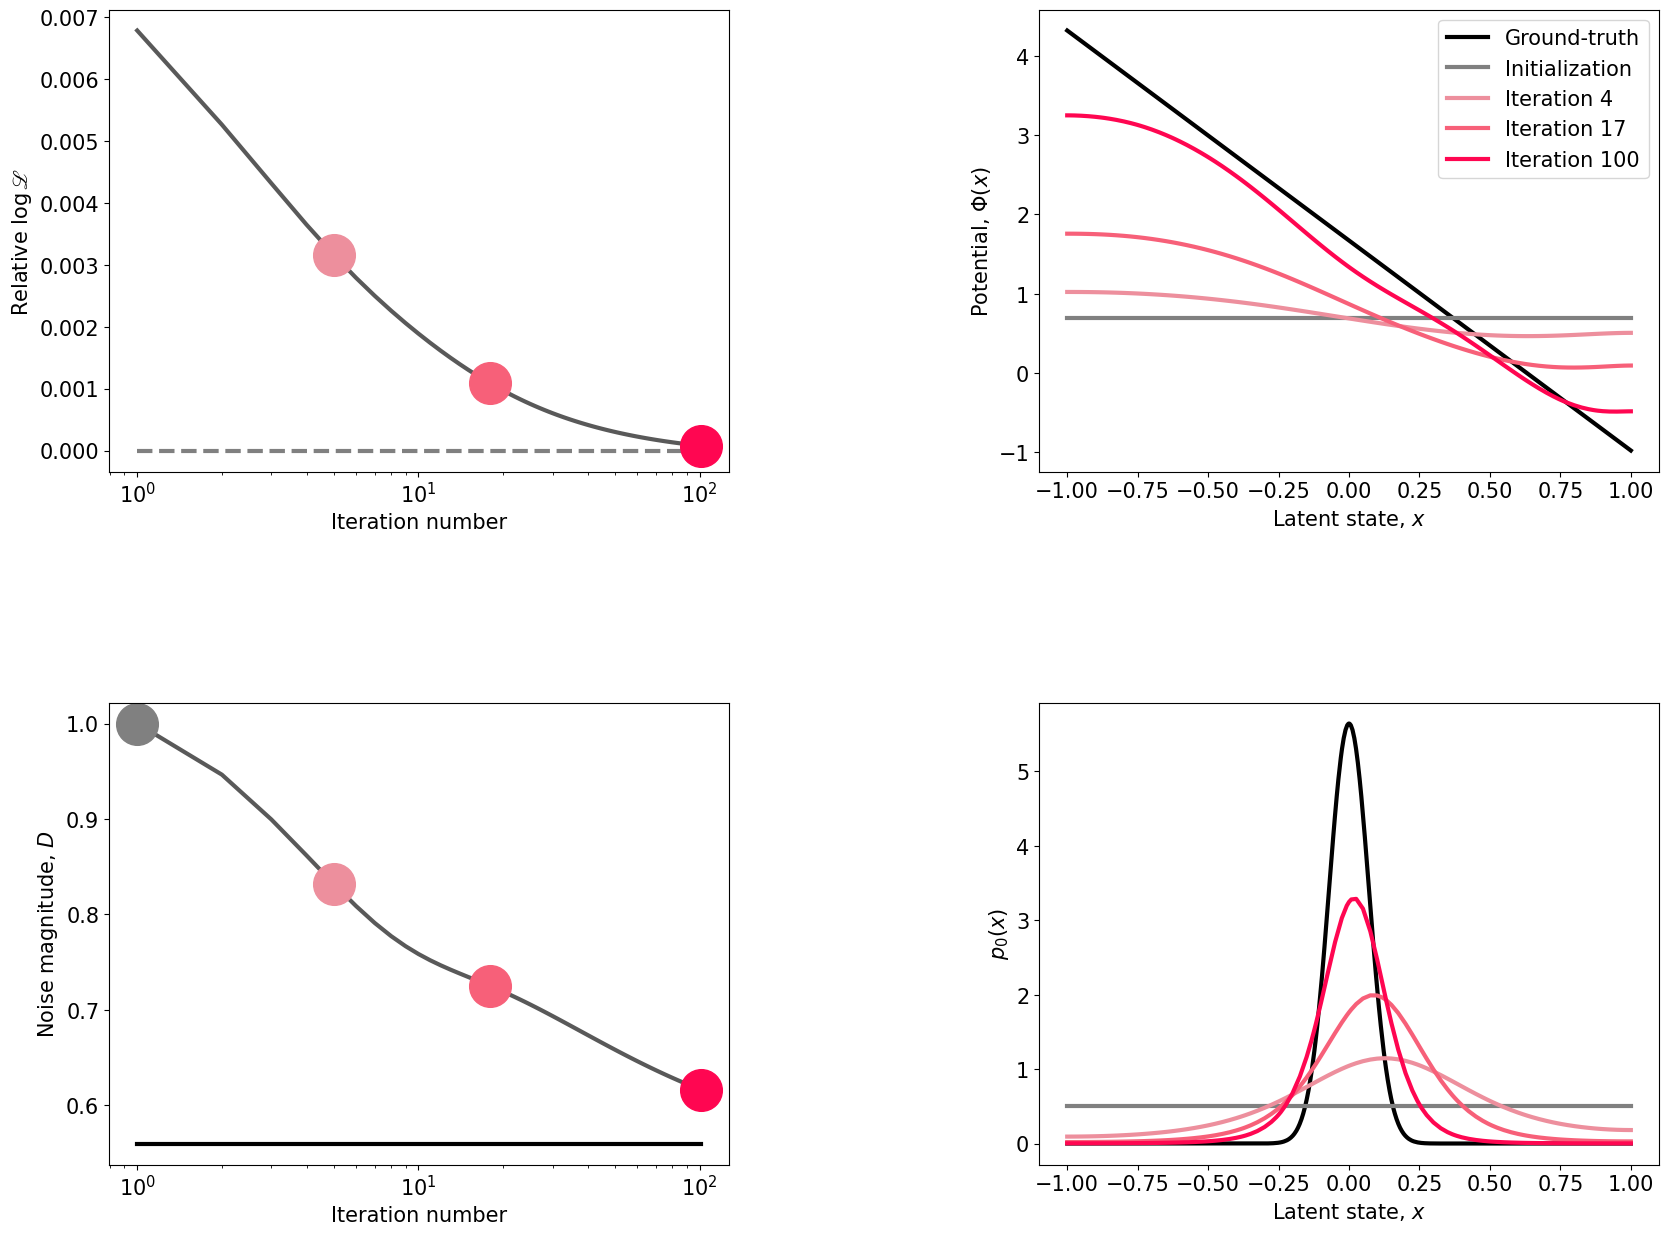

In [7]:
#Visualise the results
fig=plt.figure(figsize=(20,15))
gs=gridspec.GridSpec(2,2,wspace=0.5,hspace=0.5);
example_iterations=[4,17, optimization_ramping.results['logliks'][0].size-1]
#Plot the results for ramping model
plot_fitting_results(gs[0],gs[1], initial_guess_model, optimization_ramping.results, gt_ramping, ll_gt_ramping, example_iterations,colors)

#Plot D 
ax = plt.subplot(gs[2])
iterations_all=optimization_ramping.results['iter_num']+1
ax.plot(iterations_all,optimization_ramping.results['D'],linewidth=3,color=[0.35,0.35,0.35])
ax.plot(iterations_all[0],optimization_ramping.results['D'][0][0],'.',markersize=60,color=[0.5,0.5,0.5])
ax.plot(iterations_all, gt_ramping.D[0]*np.ones_like(iterations_all),'-',linewidth=3,color='black')
for i,iteration in enumerate(example_iterations):
    ax.plot(iterations_all[iteration],optimization_ramping.results['D'][iteration][0],'.',markersize=60,color=colors[i])

    
plt.ylabel(r'Noise magnitude, $D$',fontsize=15)
plt.xlabel('Iteration number',fontsize=15)
plt.xscale('log')
ax.tick_params(axis='both', which='major', labelsize=15)

#Plot p0
ax = plt.subplot(gs[3])
ax.plot(grid.x_d, gt_ramping.p0[0],linewidth=3,color='black',label='Ground-truth')
ax.plot(initial_guess_model.grid.x_d, optimization_ramping.results['p0'][0][0,:],linewidth=3,color=[0.5,0.5,0.5],label='Initialization')
for i,iteration in enumerate(example_iterations):
    ax.plot(initial_guess_model.grid.x_d, optimization_ramping.results['p0'][iteration][0,:],linewidth=3,color=colors[i],label='Iteration {}'.format(iteration))
#plt.legend(fontsize=15)
plt.xlabel(r'Latent state, $x$',fontsize=15)
plt.ylabel(r'$p_0(x)$',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

The code above should produce the following image:
![FIG4_3](images/Example2_3.png)